<a href="https://colab.research.google.com/github/Velociraptorvelraptor/metro-interstate-traffic-volume-LSTM-PyTorch-Lightening/blob/main/traffic_volume_LSTM_pytorch_lightening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-lightning torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 7.8 MB/s eta 0:00:00


In [2]:
src_path = '/content/drive/MyDrive/Colab Notebooks/metro-interstate-traffic-volume/'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
pd.options.mode.chained_assignment = None

In [4]:
df = pd.read_csv(src_path + 'Metro_Interstate_Traffic_Volume.csv', parse_dates=['date_time'], index_col='date_time')

In [5]:
df.head(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918


In [6]:
df.dtypes

holiday                 object
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
traffic_volume           int64
dtype: object

In [7]:
df.shape

(48204, 8)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 <a list of 11 Text major ticklabel objects>)

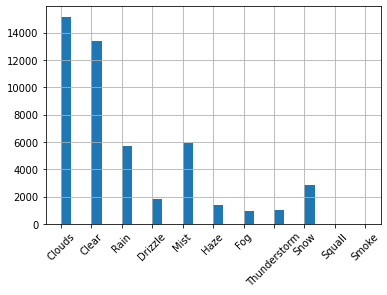

In [8]:
df['weather_main'].hist(bins=30)
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text major ticklabel objects>)

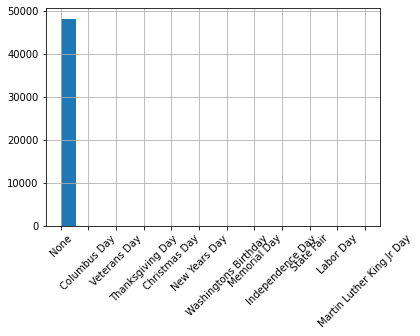

In [9]:
df['holiday'].hist(bins=20)
plt.xticks(rotation=45)

In [10]:
df[df.index.duplicated()].shape

(7629, 8)

In [11]:
df = df[~df.index.duplicated(keep='last')]

In [12]:
df.shape

(40575, 8)

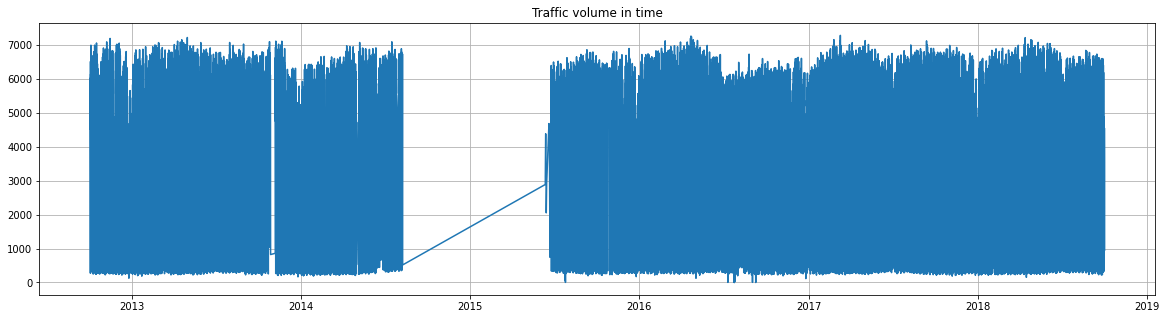

In [13]:
plt.figure(figsize=[20,5])
plt.title('Traffic volume in time')
plt.plot(df.index, df.traffic_volume)
plt.grid()

Values from mid 2014 to mid 2015 are missing, next steps will consider only data from 2015 mid and consequent.

In [14]:
date_range = pd.date_range('2012-10-02 09:00:00', '2018-09-30 23:00:00', freq='1H')

In [15]:
missing_hours = set(date_range) - set(df.index)

In [16]:
print(f'There is {len(missing_hours)} missing indexes from start to end timestamp.')

There is 11976 missing indexes from start to end timestamp.


In [17]:
df['temp'].describe()

count    40575.000000
mean       281.315009
std         13.818404
min          0.000000
25%        271.840000
50%        282.860000
75%        292.280000
max        310.070000
Name: temp, dtype: float64

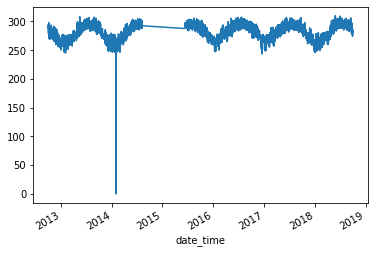

In [18]:
df['temp'].plot()

In [19]:
df['temp'] = df['temp'].replace(0, df['temp'].median())

In [20]:
df = df[df.index.year.isin([2016, 2017, 2018])].copy()

In [21]:
df = pd.concat([df.select_dtypes(include=['object']).fillna('backfill'),
                df.select_dtypes(include=['float', 'int']).interpolate()], axis=1)

In [22]:
df.head(5)

,holiday,weather_main,weather_description,temp,rain_1h,snow_1h,clouds_all,traffic_volume
date_time,,,,,,,,
2016-01-01 00:00:00,New Years Day,Snow,light snow,265.94,0.0,0.0,90,1513
2016-01-01 01:00:00,None,Snow,light snow,266.00,0.0,0.0,90,1550
2016-01-01 03:00:00,None,Snow,light snow,266.01,0.0,0.0,90,719
2016-01-01 04:00:00,None,Clouds,overcast clouds,264.80,0.0,0.0,90,533
2016-01-01 05:00:00,None,Clouds,overcast clouds,264.38,0.0,0.0,90,586


In [23]:
df.isna().sum()

holiday                0
weather_main           0
weather_description    0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
traffic_volume         0
dtype: int64

In [24]:
df = pd.get_dummies(df, columns=['holiday', 'weather_main'], drop_first=True)

In [25]:
df.drop('weather_description', axis=1, inplace=True)

In [26]:
print(f'Date start: {df.index.min()}, date end: {df.index.max()}')

Date start: 2016-01-01 00:00:00, date end: 2018-09-30 23:00:00


In [27]:
df_train = df.loc[:datetime(2017, 12, 31, 23)]

In [28]:
print(f'Train subset date start: {df_train.index.min()}, date end: {df_train.index.max()}, {df_train.shape[0]} rows.')

Train subset date start: 2016-01-01 00:00:00, date end: 2017-12-31 23:00:00, 16551 rows.


In [29]:
df_val = df.loc[datetime(2018, 1, 1, 0):datetime(2018, 6, 30, 23)]

In [30]:
print(f'Train subset date start: {df_val.index.min()}, date end: {df_val.index.max()}, {df_val.shape[0]} rows.')

Train subset date start: 2018-01-01 00:00:00, date end: 2018-06-30 23:00:00, 4329 rows.


In [31]:
df_test = df.loc[datetime(2018, 7, 1, 0):]

In [32]:
print(f'Train subset date start: {df_test.index.min()}, date end: {df_test.index.max()}, {df_test.shape[0]} rows.')

Train subset date start: 2018-07-01 00:00:00, date end: 2018-09-30 23:00:00, 2204 rows.


In [33]:
df_train.dtypes

temp                                 float64
rain_1h                              float64
snow_1h                              float64
clouds_all                             int64
traffic_volume                         int64
holiday_Columbus Day                   uint8
holiday_Independence Day               uint8
holiday_Labor Day                      uint8
holiday_Martin Luther King Jr Day      uint8
holiday_Memorial Day                   uint8
holiday_New Years Day                  uint8
holiday_None                           uint8
holiday_State Fair                     uint8
holiday_Thanksgiving Day               uint8
holiday_Veterans Day                   uint8
holiday_Washingtons Birthday           uint8
weather_main_Clouds                    uint8
weather_main_Drizzle                   uint8
weather_main_Fog                       uint8
weather_main_Haze                      uint8
weather_main_Mist                      uint8
weather_main_Rain                      uint8
weather_ma

In [34]:
scaler_dict = {}
for col in df_train.select_dtypes(include=['float', 'int']):
  scaler_dict[col] = MinMaxScaler()
  df_train[col] = scaler_dict[col].fit_transform(df_train[[col]])
  df_val[col] = scaler_dict[col].transform(df_val[[col]])
  df_test[col] = scaler_dict[col].transform(df_test[[col]])

In [35]:
class TrafficVolumeDataset(Dataset):
  def __init__(self, df, window_size=480):
    features = df
    target = df.traffic_volume

    self.x, self.y = [], []
    for i in range(len(features) - window_size):
      v = features.iloc[i: (i + window_size)].values
      self.x.append(v)
      self.y.append(target.iloc[i + window_size])

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x = self.x[index].astype(np.float32)
    y = self.y[index].astype(np.float32)
    return x, y

In [36]:
traffic_dataset = TrafficVolumeDataset(df_train)

In [37]:
traffic_dataset.__getitem__(123)

(array([[0.4774789 , 0.        , 0.        , ..., 1.        , 0.        ,
         0.        ],
        [0.47560212, 0.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        [0.47356898, 0.        , 0.52      , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.3382859 , 0.        , 0.        , ..., 1.        , 0.        ,
         0.        ],
        [0.32984048, 0.        , 0.        , ..., 1.        , 0.        ,
         0.        ],
        [0.32577416, 0.        , 0.        , ..., 1.        , 0.        ,
         0.        ]], dtype=float32), 0.03173077)

In [38]:
traffic_dataset.__getitem__(123)[0].shape

(480, 26)

In [40]:
class LSTM(pl.LightningModule):
  def __init__(self, input_size=26, output_size=1, hidden_dim=10, n_layers=2, window_size=480):
    """
    input_size: total number of features
    output_size: number of outputs expected - regression problem, so it is set to 1
    hidden_dim: total number of hidden replicas of LSTMs
    n_layers: number of LSTM layers stacked on top of each other
    windows_size: size of the window of input data
    """
    super(LSTM, self).__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers
    self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, bidirectional=False, batch_first=True)
    self.fc = nn.Linear(hidden_dim * window_size, output_size)
    self.loss = nn.MSELoss()
    self.learning_rate = 1e-4

  def get_hidden(self, batch_size):
    hidden_state = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
    cell_state = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
    return (hidden_state, cell_state)

  def forward(self, x):
    batch_size = x.size(0)
    hidden = self.get_hidden(batch_size)
    out, hidden = self.lstm(x, hidden)
    out = out.reshape(out.shape[0], -1) # flattening output to a single dim
    out = self.fc(out)
    return out

  def configure_optimizers(self):
    params = self.parameters()
    optimizer = optim.Adam(params=params, lr=self.learning_rate)
    return optimizer

  def training_step(self, batch, batch_idx):
    features, targets = batch
    x = self(features)
    x = x.view(-1)
    loss = self.loss(x, targets)
    self.log('train_loss', loss, prog_bar=True, on_epoch=True)
    return loss
  
  def validation_step(self, batch, batch_idx):
    features, targets = batch
    x = self(features)
    x = x.view(-1)
    loss = self.loss(x, targets)
    self.log('val_loss', loss, prog_bar=True, on_step=True, on_epoch=True)

In [39]:
train_dl = DataLoader(TrafficVolumeDataset(df_train), batch_size=50)
val_dl = DataLoader(TrafficVolumeDataset(df_val), batch_size=50)

In [ ]:
seed_everything(10)
model = LSTM()

INFO:lightning_lite.utilities.seed:Global seed set to 10


In [ ]:
trainer = pl.Trainer(auto_lr_find=True)
lr_finder = trainer.tuner.lr_find(model, train_dataloaders=train_dl)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=89` reached.
INFO:pytorch_lightning.tuner.lr_finder:LR finder stopped early after 89 steps due to diverging loss.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_f2245594-873e-4cfc-922d-218b77635fcd.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at /content/.lr_find_f2245594-873e-4cfc-922d-218b77635fcd.ckpt


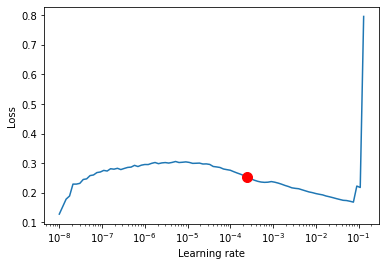

In [ ]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [ ]:
new_lr = lr_finder.suggestion()

model.learning_rate = new_lr

In [ ]:
checkpoint_callback = ModelCheckpoint(dirpath=src_path + '/checkpoints/', save_top_k=2, monitor="val_loss")

In [ ]:
trainer = pl.Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=20,
    logger=CSVLogger(save_dir=src_path+"logs/"),
    callbacks=[checkpoint_callback])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dl, val_dl)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /content/drive/MyDrive/Colab Notebooks/metro-interstate-traffic-volume/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type    | Params
---------------------------------
0 | lstm | LSTM    | 2.4 K 
1 | fc   | Linear  | 4.8 K 
2 | loss | MSELoss | 0     
---------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


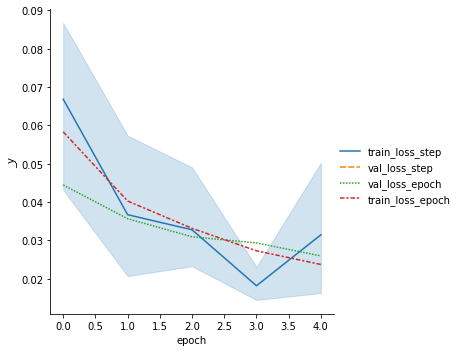

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sns.relplot(data=metrics, kind="line")

Fine-tuning with more epochs. Probably loss would keep on decreasing if trained further.

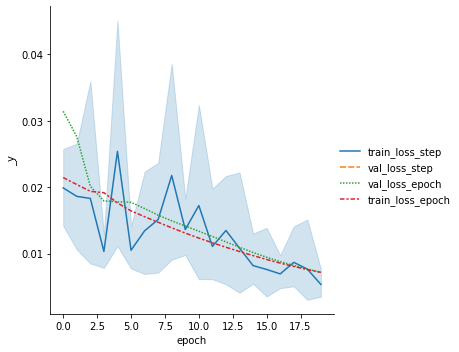

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sns.relplot(data=metrics, kind="line")

Inference on a test set

In [45]:
test_dl = DataLoader(TrafficVolumeDataset(df_test), batch_size=20)

In [63]:
champion_model = LSTM.load_from_checkpoint(src_path + "checkpoints/epoch=19-step=6440.ckpt")

In [64]:
champion_model.eval()

LSTM(
  (lstm): LSTM(26, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=4800, out_features=1, bias=True)
  (loss): MSELoss()
)

In [65]:
predicted_results, actual_results = [], []

In [66]:
for i, (features, targets) in enumerate(test_dl):
  prediction = champion_model(features)
  predicted_results.extend(prediction.view(-1).tolist())
  actual_results.extend(targets.view(-1).tolist())

In [67]:
inference_df = pd.DataFrame({
    "prediction": predicted_results,
    "actual": actual_results
})

In [68]:
inference_df.head(5)

,prediction,actual
0,0.095092,0.169643
1,0.016906,0.107280
2,-0.016077,0.089011
3,-0.027432,0.057418
4,-0.001001,0.065659


In [69]:
inverse_transformed_values = scaler_dict['traffic_volume'].inverse_transform(inference_df)

In [70]:
inference_df['prediction'] = inverse_transformed_values[:, [0]]
inference_df['actual'] = inverse_transformed_values[:, [1]]

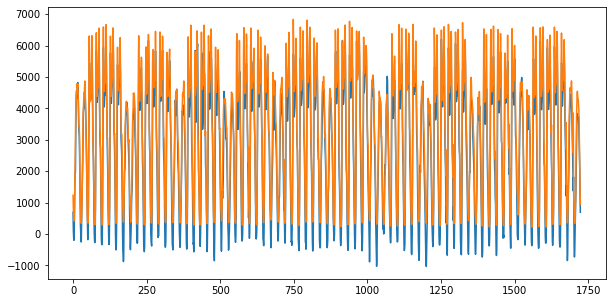

In [85]:
plt.figure(figsize=[10, 5])
plt.plot(inference_df)